In [1]:
import numpy as np
import glob
import json
import os
from PIL import Image
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
import cv2

from imgaug import augmenters as iaa
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

from augmentation import *
from model import default_categorical
from utils import linear_bin, tub_to_array, rebalance

In [2]:
def tub_file_names(tub_path):

    pics_list = glob.glob(tub_path + '/*.jpg')
    records_list = glob.glob(tub_path + "/record_*.json")

    pics_list.sort(key=lambda x: int(os.path.basename(x).split('_')[0]))
    records_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
    
    pics_names = [os.path.basename(pic) for pic in pics_list]
            
    return pics_names

In [21]:
# files name
morning_lesquare_horaire_filenames = tub_file_names(tub_20181124_morning_lesquare_horaire)
ysance_evening_filenames = tub_file_names(tub_20181121_ysance_evening)

In [4]:
# AVAILABLE TUBS
tub_20181113_42_afternoon = '/home/data/tortue-rapide/tubs/raw/tub_20181113_42_afternoon'
tub_20181113_42_evening = '/home/data/tortue-rapide/tubs/raw/tub_20181113_42_evening'
tub_20181124_morning_lesquare_horaire = '/home/data/tortue-rapide/tubs/raw/tub_20181124_morning_lesquare_horaire'
tub_20181124_morning_lesquare_antihoraire = '/home/data/tortue-rapide/tubs/raw/tub_20181124_morning_lesquare_antihoraire'
tub_20181121_ysance_evening = '/home/data/tortue-rapide/tubs/raw/tub_20181121_ysance_evening'
tub_20181122_ysance_noon = '/home/data/tortue-rapide/tubs/raw/tub_20181122_ysance_noon'

# EXAMPLES
img_example = '/home/projects/ironcar-dev/tubs/tub_20181124_morning_lesquare_antihoraire/291_cam-image_array_.jpg'
json_exple = '/home/projects/ironcar-dev/tubs/tub_20181124_morning_lesquare_antihoraire/record_291.json'

save_model_path = '/home/projects/tortue-rapide/franklin_gym/test_models'

# convert tubs to numpy arrays
# x_42_afternoon, y_42_afternoon = tub_to_array(tub_20181113_42_afternoon, n_class=3)
# x_42_evening, y_42_evening = tub_to_array(tub_20181113_42_evening, n_class=3)
x_morning_lesquare_horaire, y_morning_lesquare_horaire = tub_to_array(tub_20181124_morning_lesquare_horaire, n_class=3)
x_morning_lesquare_antihoraire, y_morning_lesquare_antihoraire = tub_to_array(tub_20181124_morning_lesquare_antihoraire, n_class=3)
X_ysance_evening, Y_ysance_evening = tub_to_array(tub_20181121_ysance_evening, n_class=3)
X_ysance_noon, Y_ysance_noon = tub_to_array(tub_20181122_ysance_noon, n_class=3)

# rebalance ecole 42 tubs  classes
# x_42_afternoon, y_42_afternoon = rebalance(x_42_afternoon, y_42_afternoon)
# x_42_evening, y_42_evening = rebalance(x_42_evening, y_42_evening)
# x_morning_lesquare_horaire, y_morning_lesquare_horaire = rebalance(x_morning_lesquare_horaire, y_morning_lesquare_horaire)

# train / validation split
# X_train = np.concatenate((x_42_afternoon, x_morning_lesquare_antihoraire, x_morning_lesquare_horaire))
# Y_train = np.concatenate((y_42_afternoon, y_morning_lesquare_antihoraire, y_morning_lesquare_horaire)) 
# X_val, Y_val = X_ysance_noon[:20000], Y_ysance_noon[:20000]

In [32]:
len(X_ysance_noon)

5114

In [30]:
X_train.shape

(309480, 160, 3)

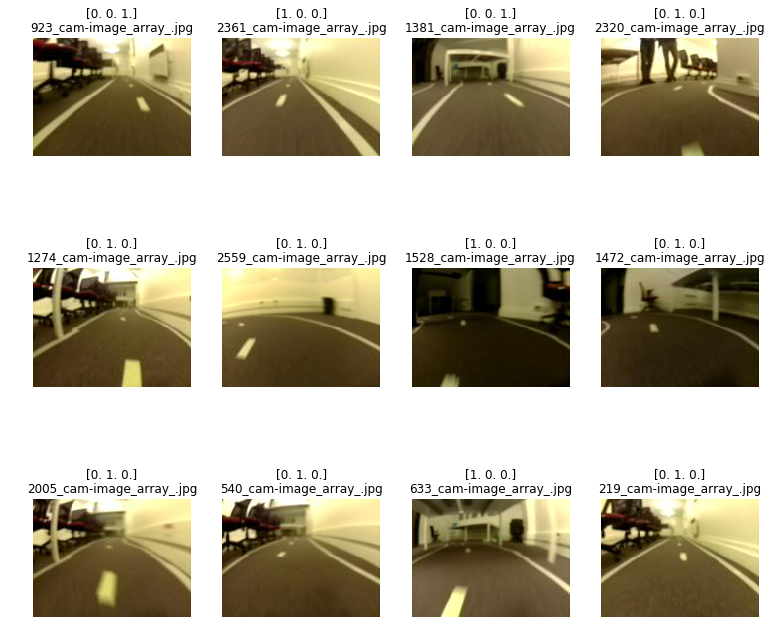

In [22]:
plt.figure(figsize=(13,12))
for n in range(12):
  plt.subplot(3,4,n+1)
  select = np.random.randint(len(Y_ysance_evening))
  plt.imshow(X_ysance_evening[select])
  plt.title(str(Y_ysance_evening[select]) + '\n' + 
            str(ysance_evening_filenames[select]))
  plt.axis('off')

In [18]:
7000/12

583.3333333333334

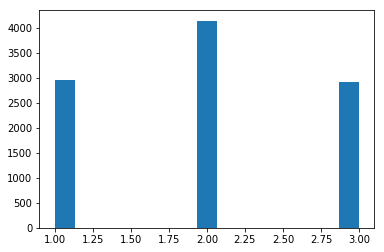

In [43]:
import matplotlib.pyplot as plt

def plot_class_histogram(Y):
    '''
    Y : categorical numpy array'''
    fi = [sum(n * a) for n in Y]
    plt.hist(fi, bins='auto')

plot_class_histogram(Y_train)

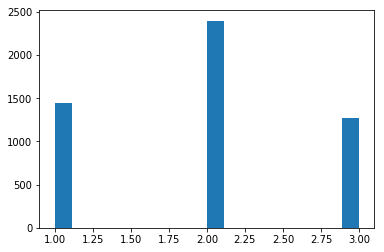

In [42]:
plot_class_histogram(Y_val)

In [2]:
# MAP DATA PREPARATION

train_tubs = ['tub_20181113_42_afternoon', 
              'tub_20181113_42_evening',
              'tub_20181124_morning_lesquare_antihoraire']
validation_tubs = ['tub_20181122_ysance_noon']

rebalance_tubs = ['tub_20181113_42_afternoon', 
                  'tub_20181113_42_evening']

# 'tweak_luminosity'
# 'add_snow'
# 'add_shadow'
# 'add_blur'
# 'add_gaussian_noise'
# 'random_shadows'
# 'generate_night_effect' 
# 'generate_brightness'
# 'generate_contrast_normalization'
augmentation_functions = ['tweak_luminosity', 'generate_contrast_normalization']

PROPORTION = 0.1

In [48]:
print('{} samples'.format(len(X_train)))

for augment in augmentation_functions:
    if augment in transform_dict.keys():
        print(augment)
        f = transform_dict[augment]
        X_transfo, Y_transfo = transform(X_train, Y_train, transformation=f, proportion=PROPORTION)
        X_train = np.concatenate((X_train, X_transfo))
        Y_train = np.concatenate((Y_train, Y_transfo)) 
        

print('{} samples'.format(len(X_train)))

 21%|██        | 251/1210 [00:00<00:00, 2505.63it/s]

12100 samples
tweak_luminosity


100%|██████████| 1210/1210 [00:00<00:00, 2917.45it/s]


13310 samples


In [11]:
len(X_train)

7965

In [220]:
image_ori = np.concatenate((image_ori, image_HLS))

In [221]:
image_ori.shape

(125, 120, 160, 3)

In [ ]:
bight_x_train_5eme, bright_y_train_5eme = aug.generate_brightness(X_train, Y_train)
bight_x_train_5eme, bright_y_train_5eme = aug.generate_night_effect(X_train, Y_train)
bight_x_train_5eme, bright_y_train_5eme = aug.generate_random_shadows(X_train, Y_train)

In [ ]:
# fit model

epochs=100
steps=100
verbose=1
min_delta=.0005
patience=5
use_early_stop=True


model = default_categorical()

# checkpoint to save model after each epoch
save_best = ModelCheckpoint(save_model_path,
                            monitor='val_loss',
                            verbose=verbose,
                            save_best_only=True,
                            mode='min')

# stop training if the validation error stops improving.
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=min_delta,
                           patience=patience,
                           verbose=verbose,
                           mode='auto')

callbacks_list = [save_best]

if use_early_stop:
    callbacks_list.append(early_stop)

model.summary()
    
# fit from numpy array
hist = model.fit(x=X_train,
                 y=Y_train,
                 steps_per_epoch=steps,
                 epochs=epochs,
                 verbose=1,
                 validation_data=(X_val, Y_val),
                 callbacks=callbacks_list,
                 validation_steps=200/8)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 120, 160, 3)       0         
_________________________________________________________________
cropping2d_2 (Cropping2D)    (None, 80, 160, 3)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 38, 78, 24)        1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 17, 37, 32)        19232     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 17, 64)         51264     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 8, 64)          36928     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 6, 64)          36928     
__________

In [3]:
x_42_afternoon[0]

array([[[ 91, 123,  73],
        [102, 131,  83],
        [ 92, 121,  73],
        ...,
        [  2,  28,   0],
        [ 34,  60,  31],
        [ 45,  71,  42]],

       [[ 78, 110,  61],
        [105, 134,  88],
        [ 98, 125,  82],
        ...,
        [  0,  19,   0],
        [  1,  27,   0],
        [ 10,  36,   7]],

       [[ 91, 120,  76],
        [120, 148, 107],
        [110, 136,  97],
        ...,
        [ 28,  54,  25],
        [  0,  29,   0],
        [  0,  19,   0]],

       ...,

       [[ 55,  73,  15],
        [ 55,  73,  15],
        [ 56,  73,  18],
        ...,
        [ 52,  66,   7],
        [ 48,  62,   3],
        [ 46,  60,   1]],

       [[ 54,  74,  15],
        [ 54,  74,  15],
        [ 55,  75,  16],
        ...,
        [ 49,  63,   4],
        [ 54,  68,   9],
        [ 64,  78,  19]],

       [[ 54,  74,  15],
        [ 54,  74,  15],
        [ 55,  75,  16],
        ...,
        [ 53,  67,   8],
        [ 75,  89,  30],
        [ 99, 113,  54]]

In [6]:
%%bash 
pip install --upgrade pip

Looking in indexes: https://rec-nexus.dmp.y-track.com/repository/pypi-all/simple
  Using cached https://rec-nexus.dmp.y-track.com/repository/pypi-all/packages/d8/f3/413bab4ff08e1fc4828dfc59996d721917df8e8583ea85385d51125dceff/pip-19.0.3-py2.py3-none-any.whl
  Found existing installation: pip 18.1
    Uninstalling pip-18.1:
      Successfully uninstalled pip-18.1
